In [710]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import sqlite3

In [711]:
Fitbit_dir = "./Fitbit_05042022/ShiYangLee/Physical Activity/heart_rate-2022-03-29.json"

In [712]:
df_fitbit = pd.read_json(Fitbit_dir)

In [713]:
df_fitbit.head()

,dateTime,value
0,2022-03-28 23:00:06,"{'bpm': 56, 'confidence': 3}"
1,2022-03-28 23:00:21,"{'bpm': 56, 'confidence': 3}"
2,2022-03-28 23:00:31,"{'bpm': 57, 'confidence': 3}"
3,2022-03-28 23:00:41,"{'bpm': 58, 'confidence': 3}"
4,2022-03-28 23:00:46,"{'bpm': 57, 'confidence': 3}"


In [714]:
df_fitbit.value.dtype

dtype('O')

In [715]:
df_fitbit.isnull().sum()

dateTime    0
value       0
dtype: int64

In [716]:
def data_split(data):
    if 'value' not in data.columns:
        print("The dataframe is already splitted!")
        return
    data['value'] = data['value'].astype('str')
    tmp = data.value.str.split(' ', expand = True)
    data[['bpm', 'confidence']] = tmp[[1, 3]]
    strip_col = ['bpm', 'confidence']
    data[strip_col] = data[strip_col].apply(lambda x: x.str.strip(",} "))
    print(data)
    data.drop("value", axis = 1, inplace = True)
    print(data)

In [717]:
data_split(df_fitbit)

                 dateTime                         value bpm confidence
0     2022-03-28 23:00:06  {'bpm': 56, 'confidence': 3}  56          3
1     2022-03-28 23:00:21  {'bpm': 56, 'confidence': 3}  56          3
2     2022-03-28 23:00:31  {'bpm': 57, 'confidence': 3}  57          3
3     2022-03-28 23:00:41  {'bpm': 58, 'confidence': 3}  58          3
4     2022-03-28 23:00:46  {'bpm': 57, 'confidence': 3}  57          3
...                   ...                           ...  ..        ...
11351 2022-03-29 22:59:38  {'bpm': 75, 'confidence': 3}  75          3
11352 2022-03-29 22:59:43  {'bpm': 79, 'confidence': 2}  79          2
11353 2022-03-29 22:59:48  {'bpm': 73, 'confidence': 2}  73          2
11354 2022-03-29 22:59:53  {'bpm': 68, 'confidence': 3}  68          3
11355 2022-03-29 22:59:58  {'bpm': 64, 'confidence': 3}  64          3

[11356 rows x 4 columns]
                 dateTime bpm confidence
0     2022-03-28 23:00:06  56          3
1     2022-03-28 23:00:21  56          3

In [718]:
def fitbit_dataprep(df_fitbit):
    print(df_fitbit.bpm.dtype)
    if df_fitbit.bpm.dtype == int:
        print("The dataframe was already prepared!")
        return
    df_fitbit = df_fitbit.set_index('dateTime')
    print(df_fitbit)
    df_fitbit['bpm'] = df_fitbit['bpm'].astype('int')
    df_fitbit['confidence'] = df_fitbit['confidence'].astype('int')
    df_fitbit.index = pd.to_datetime(df_fitbit.index, format = '%Y-%m-%d %H:%M:%S')
    return df_fitbit

In [719]:
df_fitbit = fitbit_dataprep(df_fitbit)

object
                    bpm confidence
dateTime                          
2022-03-28 23:00:06  56          3
2022-03-28 23:00:21  56          3
2022-03-28 23:00:31  57          3
2022-03-28 23:00:41  58          3
2022-03-28 23:00:46  57          3
...                  ..        ...
2022-03-29 22:59:38  75          3
2022-03-29 22:59:43  79          2
2022-03-29 22:59:48  73          2
2022-03-29 22:59:53  68          3
2022-03-29 22:59:58  64          3

[11356 rows x 2 columns]


In [720]:
df_fitbit.index = df_fitbit.index.shift(1, freq='H')

In [721]:
tmp = pd.date_range('2022-03-29 00:00', '2022-3-30 00:00', freq = 'T')
tmp

DatetimeIndex(['2022-03-29 00:00:00', '2022-03-29 00:01:00',
               '2022-03-29 00:02:00', '2022-03-29 00:03:00',
               '2022-03-29 00:04:00', '2022-03-29 00:05:00',
               '2022-03-29 00:06:00', '2022-03-29 00:07:00',
               '2022-03-29 00:08:00', '2022-03-29 00:09:00',
               ...
               '2022-03-29 23:51:00', '2022-03-29 23:52:00',
               '2022-03-29 23:53:00', '2022-03-29 23:54:00',
               '2022-03-29 23:55:00', '2022-03-29 23:56:00',
               '2022-03-29 23:57:00', '2022-03-29 23:58:00',
               '2022-03-29 23:59:00', '2022-03-30 00:00:00'],
              dtype='datetime64[ns]', length=1441, freq='T')

In [722]:
loc = [df_fitbit.index.get_loc(x, "nearest") for x in tmp]
df_fitbit = df_fitbit.iloc[loc]
df_fitbit.index = df_fitbit.index.round(freq = "T")

In [723]:
df_fitbit

,bpm,confidence
dateTime,,
2022-03-29 00:00:00,56,3
2022-03-29 00:01:00,58,3
2022-03-29 00:02:00,56,3
2022-03-29 00:03:00,56,3
2022-03-29 00:04:00,55,3
...,...,...
2022-03-29 23:56:00,55,3
2022-03-29 23:57:00,57,3
2022-03-29 23:58:00,56,3


In [724]:
print(df_fitbit.head())

                     bpm  confidence
dateTime                            
2022-03-29 00:00:00   56           3
2022-03-29 00:01:00   58           3
2022-03-29 00:02:00   56           3
2022-03-29 00:03:00   56           3
2022-03-29 00:04:00   55           3


In [725]:
!ls ./HealthData/DBs

fitbit.db	      garmin.db		    garmin_summary.db  summary.db
garmin_activities.db  garmin_monitoring.db  mshealth.db


In [726]:
garmin_db = "./HealthData/DBs/garmin.db"
con = sqlite3.connect(garmin_db)
cur = con.cursor()
table = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con)
table

,name
0,_attributes
1,attributes
2,devices
3,weight
4,stress
5,sleep
6,sleep_events
7,resting_hr
8,daily_summary
9,files


In [727]:
garmin_df = pd.read_sql_query("SELECT * FROM resting_hr", con)
garmin_df.head()

,day,resting_heart_rate
0,2022-03-27,67.0
1,2022-03-24,52.0
2,2022-04-02,60.0
3,2022-03-26,52.0
4,2022-03-29,50.0


In [728]:
garmin_monit_db = "./HealthData/DBs/garmin_monitoring.db"
garmin_monit_con = sqlite3.connect(garmin_monit_db)
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", garmin_monit_con)

,name
0,_attributes
1,monitoring_info
2,monitoring_hr
3,monitoring_intensity
4,monitoring_climb
5,monitoring
6,monitoring_rr
7,monitoring_pulse_ox


In [729]:
pd.read_sql_query("SELECT * FROM monitoring", garmin_monit_con)

,timestamp,activity_type,intensity,duration,distance,cum_active_time,active_calories,steps,strokes,cycles
0,2022-03-24 18:20:00.000000,generic,NaN,18:20:00.000000,1.13,00:32:39.000000,117.0,NaN,None,0.0
1,2022-03-24 18:20:00.000000,walking,NaN,18:20:00.000000,6665.77,02:01:20.000000,408.0,8489.0,None,4244.5
2,2022-03-24 18:20:00.000000,running,NaN,18:20:00.000000,166.01,00:01:34.000000,0.0,139.0,None,69.5
3,2022-03-24 18:22:00.000000,stop_disable,3.0,00:00:00.000000,NaN,00:00:00.000000,NaN,NaN,None,NaN
4,2022-03-24 18:22:00.000000,generic,NaN,18:22:00.000000,1.13,00:32:39.000000,117.0,NaN,None,0.0
...,...,...,...,...,...,...,...,...,...,...
6610,2022-04-02 10:47:00.000000,stop_disable,0.0,00:00:00.000000,NaN,00:00:00.000000,NaN,NaN,None,NaN
6611,2022-04-02 10:48:00.000000,stop_disable,2.0,00:00:00.000000,NaN,00:00:00.000000,NaN,NaN,None,NaN
6612,2022-04-02 10:49:00.000000,stop_disable,0.0,00:00:00.000000,NaN,00:00:00.000000,NaN,NaN,None,NaN
6613,2022-04-02 10:51:00.000000,stop_disable,4.0,00:00:00.000000,NaN,00:00:00.000000,NaN,NaN,None,NaN


In [730]:
info = pd.read_sql_query("SELECT * FROM monitoring_info", garmin_monit_con)
info

,timestamp,file_id,activity_type,resting_metabolic_rate,cycles_to_distance,cycles_to_calories
0,2022-03-24 18:20:00.000000,129844478804,walking,1876,1.5924,0.036258
1,2022-03-24 18:20:00.000000,129844478804,running,1876,2.3886,0.114551
2,2022-03-26 13:11:00.000000,130084718422,walking,1876,1.5924,0.036258
3,2022-03-26 13:11:00.000000,130084718422,running,1876,2.3886,0.114551
4,2022-03-31 03:51:00.000000,130761492107,walking,1876,1.5924,0.036258
...,...,...,...,...,...,...
549,2022-04-05 19:25:00.000000,131522625880,running,1876,2.3886,0.114551
550,2022-03-25 22:17:00.000000,129999621058,walking,1876,1.5924,0.036258
551,2022-03-25 22:17:00.000000,129999621058,running,1876,2.3886,0.114551
552,2022-04-02 10:35:00.000000,131033327923,walking,1876,1.5924,0.036258


In [731]:
garmin_hr = pd.read_sql_query("SELECT * FROM monitoring_hr", garmin_monit_con)
garmin_hr

,timestamp,heart_rate
0,2022-03-24 18:21:00.000000,72
1,2022-03-26 13:13:00.000000,72
2,2022-03-26 13:14:00.000000,73
3,2022-03-26 13:18:00.000000,72
4,2022-03-26 13:19:00.000000,73
...,...,...
13911,2022-04-02 10:48:00.000000,60
13912,2022-04-02 10:49:00.000000,62
13913,2022-04-02 10:50:00.000000,60
13914,2022-04-02 10:51:00.000000,69


In [732]:
garmin_0329_hr = garmin_hr.loc[(garmin_hr['timestamp'] >= '2022-03-29') & \
                               (garmin_hr['timestamp'] < '2022-03-30')]
garmin_0329_hr.set_index('timestamp', inplace = True)
garmin_0329_hr.index = pd.to_datetime(garmin_0329_hr.index, format = "%Y-%m-%d %H:%M:%S.%f")
garmin_0329_hr.to_csv('tmp.csv')
print(garmin_0329_hr)

                     heart_rate
timestamp                      
2022-03-29 09:29:00         117
2022-03-29 09:30:00         123
2022-03-29 09:31:00         110
2022-03-29 09:32:00          97
2022-03-29 09:33:00          92
...                         ...
2022-03-29 23:56:00          55
2022-03-29 23:57:00          56
2022-03-29 23:58:00          57
2022-03-29 23:59:00          56
2022-03-29 23:59:59          58

[1036 rows x 1 columns]


In [733]:
garmin_0329_hr = garmin_0329_hr.reindex(tmp)
def average_fill(data):
    return data.ffill().fillna(method = 'bfill').\
                    add(garmin_0329_hr.bfill().fillna(method = 'ffill')).div(2)
garmin_0329_hr = average_fill(garmin_0329_hr)
print(garmin_0329_hr)
garmin_0329_hr.isnull().sum()

                     heart_rate
2022-03-29 00:00:00        55.0
2022-03-29 00:01:00        55.0
2022-03-29 00:02:00        55.0
2022-03-29 00:03:00        55.0
2022-03-29 00:04:00        56.0
...                         ...
2022-03-29 23:56:00        55.0
2022-03-29 23:57:00        56.0
2022-03-29 23:58:00        57.0
2022-03-29 23:59:00        56.0
2022-03-30 00:00:00        56.0

[1441 rows x 1 columns]


heart_rate    0
dtype: int64

<AxesSubplot:xlabel='dateTime', ylabel='Heart Rate'>

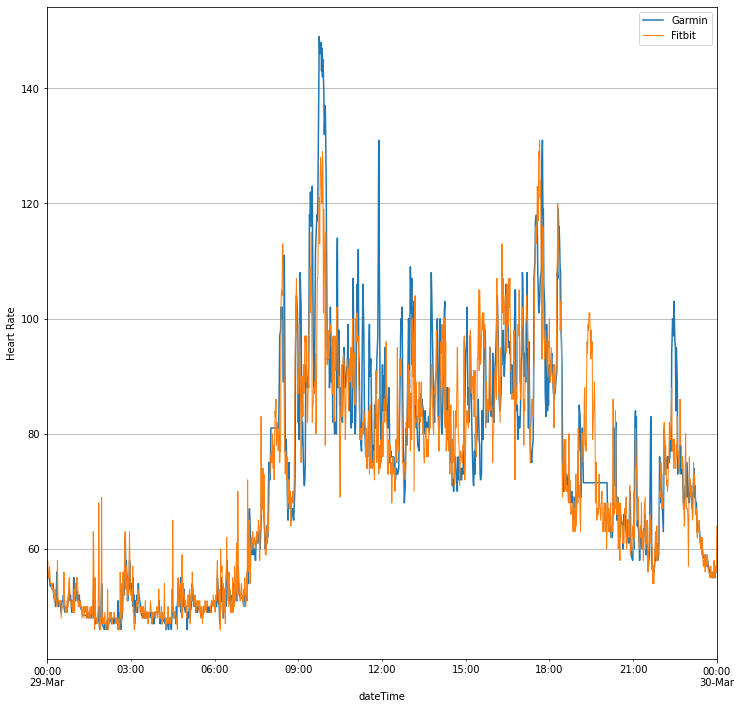

In [738]:
garmin_0329_hr.plot(y = 'heart_rate', use_index=True,  kind = 'line', \
                    figsize = (12,12), label = 'Garmin', grid = True, ylabel = 'Heart Rate')
df_fitbit['bpm'].plot(y = 'bpm', grid = True, kind = 'line', linewidth = 1 \
                      ,  label = 'Fitbit', legend = True)

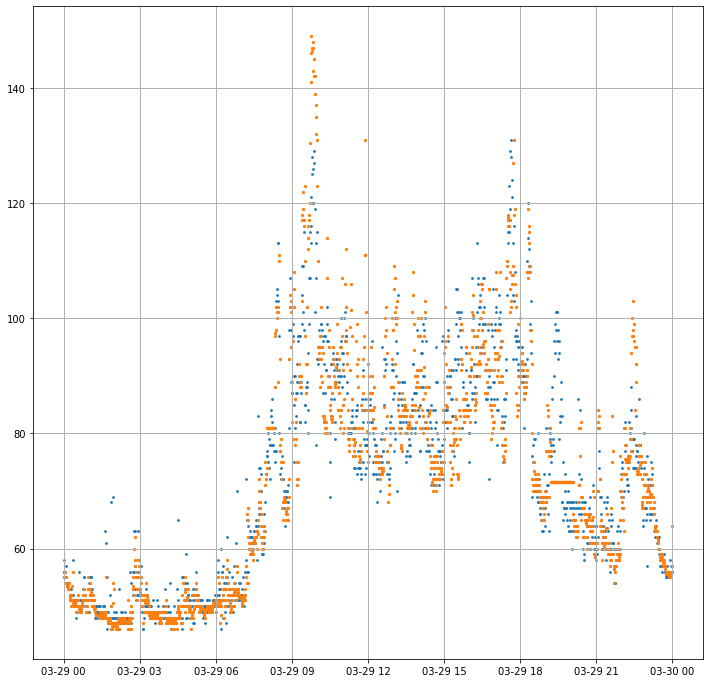

In [739]:
plt.rcParams["figure.figsize"] = (12,12)
plt.scatter(df_fitbit.index, y = 'bpm', s=3,  data = df_fitbit )
plt.scatter(garmin_0329_hr.index, y = 'heart_rate', s=5,  data = garmin_0329_hr )
plt.grid(linestyle='-', linewidth=1)

In [736]:
df_fitbit['bpm']

dateTime
2022-03-29 00:00:00    56
2022-03-29 00:01:00    58
2022-03-29 00:02:00    56
2022-03-29 00:03:00    56
2022-03-29 00:04:00    55
                       ..
2022-03-29 23:56:00    55
2022-03-29 23:57:00    57
2022-03-29 23:58:00    56
2022-03-29 23:59:00    56
2022-03-30 00:00:00    64
Name: bpm, Length: 1441, dtype: int64

In [737]:
garmin_0329_hr.sort_index()

,heart_rate
2022-03-29 00:00:00,55.0
2022-03-29 00:01:00,55.0
2022-03-29 00:02:00,55.0
2022-03-29 00:03:00,55.0
2022-03-29 00:04:00,56.0
...,...
2022-03-29 23:56:00,55.0
2022-03-29 23:57:00,56.0
2022-03-29 23:58:00,57.0
2022-03-29 23:59:00,56.0
